In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'FMT')))
from FMT.vae import VAE
from train_vae import FrameDataset
import torch
import matplotlib.pyplot as plt
import numpy as np

/home/haoyuexiao/Documents/CS280/final_proj/CS280-_Project_autoregressive_diffusuon/cs280_project


In [2]:
from FMT.config.AutoregressiveFMTConfig import AutoregressiveFMTConfig
from FMT.model import AutoregressiveFMT
config = AutoregressiveFMTConfig()
model = AutoregressiveFMT(config)
state_dict = torch.load('/home/haoyuexiao/Documents/CS280/final_proj/CS280-_Project_autoregressive_diffusuon/cs280_project/scripts/checkpoints/autoregressive_fmt_50/model_epoch10.pth')
model.load_state_dict(state_dict)

/home/haoyuexiao/Documents/CS280/final_proj/CS280-_Project_autoregressive_diffusuon/cs280_project/FMT/model.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch

[AutoregressiveFMT] loaded VAE weights from /home/haoyuexiao/Documents/CS280/final_proj/CS280-_Project_autoregressive_diffusuon/cs280_project/scripts/checkpoints/vae_50/best.pth


/tmp/ipykernel_3678260/761383533.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/home/haoyuexiao/Documents/CS280/final_proj/CS280-_Project_auto

<All keys matched successfully>

In [3]:
for n,p in model.named_parameters():
    if p.requires_grad:
        print(n, p.device, p.grad is None)


fmt.frame_embed.weight cuda:0 True
fmt.frame_embed.bias cuda:0 True
fmt.time_embed.mlp.0.weight cuda:0 True
fmt.time_embed.mlp.0.bias cuda:0 True
fmt.time_embed.mlp.2.weight cuda:0 True
fmt.time_embed.mlp.2.bias cuda:0 True
fmt.class_embed.ff.0.weight cuda:0 True
fmt.class_embed.ff.0.bias cuda:0 True
fmt.class_embed.ff.2.weight cuda:0 True
fmt.class_embed.ff.2.bias cuda:0 True
fmt.blocks.0.norm1.weight cuda:0 True
fmt.blocks.0.norm1.bias cuda:0 True
fmt.blocks.0.attn.qkv.weight cuda:0 True
fmt.blocks.0.attn.qkv.bias cuda:0 True
fmt.blocks.0.attn.proj.weight cuda:0 True
fmt.blocks.0.attn.proj.bias cuda:0 True
fmt.blocks.0.norm2.weight cuda:0 True
fmt.blocks.0.norm2.bias cuda:0 True
fmt.blocks.0.mlp.fc1.weight cuda:0 True
fmt.blocks.0.mlp.fc1.bias cuda:0 True
fmt.blocks.0.mlp.fc2.weight cuda:0 True
fmt.blocks.0.mlp.fc2.bias cuda:0 True
fmt.blocks.0.mod.1.weight cuda:0 True
fmt.blocks.0.mod.1.bias cuda:0 True
fmt.blocks.1.norm1.weight cuda:0 True
fmt.blocks.1.norm1.bias cuda:0 True
fmt.bl

In [16]:
one_hot = torch.Tensor([1, 0]).unsqueeze(0).cuda()
sampled_video = model.autoregressive_sample(one_hot, num_chunks=100, guidance=7.0, seed=5154)[0]
print(sampled_video.shape)

torch.Size([400, 1, 256, 256])


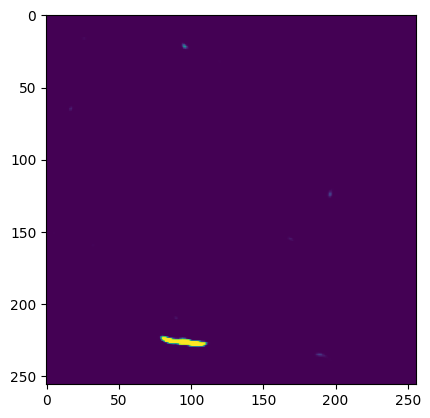

In [17]:
sampled_video_numpy = sampled_video.permute(0, 2, 3, 1).cpu().numpy()
for i, frame in enumerate(sampled_video_numpy):
    if i  == 1:
        plt.imshow(frame)
        break

In [18]:
import imageio
gif_path = os.path.join(os.getcwd(), 'output_video.gif')
video_numpy_int = (sampled_video_numpy * 255).squeeze(-1)  .astype(np.uint8)
imageio.mimsave(gif_path, video_numpy_int, fps=10)



In [3]:
from dataset import QuickDrawDataset
data_path = '../data/quickdraw_50_apple_star_v2.npz'
valid_ds  = QuickDrawDataset(data_path, split="valid", num_classes=2)

torch.Size([60, 256, 256])


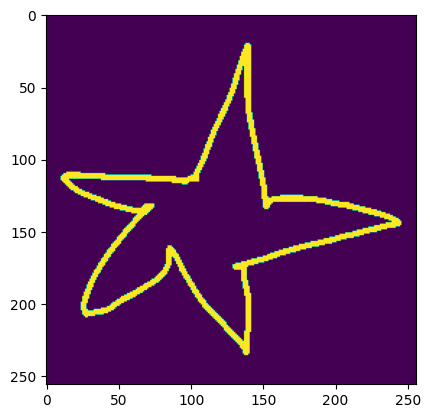

In [17]:
idx = 6
video, labels = valid_ds[idx]
print(video.shape)

for i, frame in enumerate(video):
    if i == 59:
        plt.imshow(frame)
        plt.show()
        break


In [18]:
first_chunk = video[:12, ...].unsqueeze(0).unsqueeze(2).cuda()
print(first_chunk.shape)
sampled_video_cond = model.autoregressive_sample(labels.unsqueeze(0).cuda(), num_chunks=100, guidance=5.0, seed=5154, prev_chunk=first_chunk)[0]
print(sampled_video_cond.shape)


torch.Size([1, 12, 1, 256, 256])
torch.Size([400, 1, 256, 256])


In [19]:
import imageio
gif_path = os.path.join(os.getcwd(), 'output_video_cond.gif')
print(sampled_video_cond.shape)
video_cond_numpy_int = (sampled_video_cond.permute(0, 2, 3, 1).cpu().numpy() * 255).squeeze(-1)  .astype(np.uint8)
imageio.mimsave(gif_path, video_cond_numpy_int, fps=10)



torch.Size([400, 1, 256, 256])
